In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import math

from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")

C:\Users\Usrer\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\Usrer\AppData\Local\Programs\Python\Python310\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise,

# Simple Pre-processing
1. Removes Stopwords
2. Convert all to lowercases
3. Removes Punctuations
4. Removes hyperlink
5. Removes special characters

In [3]:
from gensim.parsing.preprocessing import remove_stopwords
import string
import re

In [15]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def lower_case(text):
    return text.lower()

def combine_features(keyword, text):
    if keyword is np.nan:
        keyword = ""
    
    return text + keyword

combine_features = np.vectorize(combine_features)

def remove_url(text):
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)
    
    return text

def remove_special_characters(text):
    text = re.sub(r"[^A-Za-z0-9\s]+", "", text)
    
    return text


In [18]:
train_df = pd.read_csv("dataset\\train.csv")
test_df = pd.read_csv("dataset\\test.csv")

In [19]:
train_df['text'] = combine_features(train_df['keyword'], train_df['text'])
train_df['text'] = train_df['text'].apply(remove_stopwords)
train_df['text'] = train_df['text'].apply(remove_punctuation)
train_df['text'] = train_df['text'].apply(lower_case)
train_df['text'] = train_df['text'].apply(remove_url)
train_df['text'] = train_df['text'].apply(remove_special_characters)

test_df['text'] = combine_features(test_df['keyword'], test_df['text'])
test_df['text'] = test_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(remove_punctuation)
test_df['text'] = test_df['text'].apply(lower_case)
test_df['text'] = test_df['text'].apply(remove_url)
test_df['text'] = test_df['text'].apply(remove_special_characters)

In [20]:
train_data = train_df[['text', 'target']].copy()

X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['target'], test_size=0.2, random_state=42)

# Approach 1: Using simpletransformers' BERT + Classification Model to predict

In [5]:
model_args = ClassificationArgs(num_train_epochs=1)

model = ClassificationModel(
    "bert",
    "bert-base-uncased",
    args=model_args,
    use_cuda=False
)

model.train_model(pd.merge(X_train, y_train, right_index=True, left_index=True))

result, model_outputs, wrong_predictions = model.eval_model(pd.merge(X_test, y_test, right_index=True, left_index=True))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

  0%|          | 0/6090 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1523 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/191 [00:00<?, ?it/s]

In [37]:
result

{'mcc': 0.5491845405525937,
 'tp': 475,
 'tn': 713,
 'fp': 161,
 'fn': 174,
 'auroc': 0.8552287800629731,
 'auprc': 0.8487481102263537,
 'eval_loss': 0.4651073358992007}

In [60]:
ids = test_df[['id']]
pred = pd.Series(model.predict(test_df['text'].tolist())[0])
submission = pd.concat([ids, pred], axis=1).rename(columns={0: 'target'})
submission.to_csv('submission.csv', index=False)

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

# Approach 2: BERT from Tensorflow Hub (Best Score: 0.81274)

In [94]:
preprocessor = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

bert_preprocessor_model = hub.KerasLayer(preprocessor)
bert_model = hub.KerasLayer(encoder)

In [93]:
### Below is the preprocessor's output
# input ids
# word ids
# input mask
bert_preprocessor_model(["this is such an amazing movie!!!!!"])

{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>,
 'input_word_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[ 101, 2023, 2003, 2107, 2019, 6429, 3185,  999,  999,  999,  999,
          999,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0

Source: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is [`batch_size`, `H`]. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is [`batch_size`, `seq_length`, `H`]. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [`batch_size`, `seq_length`, `1024`] with the outputs of the i-th Transformer block, `for 0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the pooled_output array.

## BERT Development

In [36]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).batch(8)

test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(8)

In [54]:
class BERTClassfier:
    def __init__(self):
        
        # random seed for reproducibility
        tf.random.set_seed(42)
        
        # tensorflow hub urls 
        PREPROCESSOR = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
        ENCODER = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
        
        # model development
        input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_layer")
        preprocessing_layer = hub.KerasLayer(PREPROCESSOR, name="preprocessing_layer")
        encoder_inputs = preprocessing_layer(input_layer)
        encoder = hub.KerasLayer(ENCODER, trainable=True, name='BERT_encoder')
        outputs = encoder(encoder_inputs)
        
        # fine-tuning (output layer, basically defining classifier layer)
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.3)(net)
        net = tf.keras.layers.Dense(1, activation=None, name="Classifier")(net)
        
        self.model = tf.keras.Model(input_layer, net)
        
        # model loss function
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) # binary classification
        metrics = tf.metrics.BinaryAccuracy()
        
        # optimizer
        self.epochs = 5 # hardcoded as 5
        steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        num_warmup_steps = int(0.1 * num_train_steps)
        
        initial_learning_rate = 3e-5
        optimizer = optimization.create_optimizer(
            init_lr=initial_learning_rate,
            num_train_steps=num_train_steps,
            num_warmup_steps=num_warmup_steps,
            optimizer_type="adamw"
        )
        
        self.model.compile(
            loss=loss,
            optimizer=optimizer,
            metrics=metrics
        )
        
    def train(self, train_ds, test_ds):
        earlystop_callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=2
        )
        
        self.history = self.model.fit(
            x=train_ds,
            validation_data=test_ds,
            epochs=self.epochs,
            callbacks=[earlystop_callback]
        )
        
        return self.history
    
    def get_model(self):
        return self.model
    
    def evaluate(self, test_ds):
        loss, accuracy = self.model.evaluate(test_ds)
        
        print(f'Loss: {loss}')
        print(f'Accuracy: {accuracy}')
        
    def iteration_plot(self):
        history = self.history.history
        
        acc = history['binary_accuracy']
        val_acc = history['val_binary_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
        
        epochs = range(1, len(acc) + 1)
        fig = plt.figure(figsize=(10, 6))
        fig.tight_layout()
        
        plt.subplot(2, 1, 1)
        # r is for "solid red line"
        plt.plot(epochs, loss, 'r', label='Training loss')
        # b is for "solid blue line"
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        # plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, acc, 'r', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
    
    def save_model(self):
        self.model.save("./", include_optimizer=False)
        
    def predict(self, text):
        pred = tf.sigmoid(self.model.predict(text)).numpy()
        pred = np.where(pred.reshape(-1) > 0.5, 1, 0)
        
        return pd.Series(pred)
        

In [55]:
bert = BERTClassfier()
history = bert.train(train_ds, test_ds)

Epoch 1/5
762/762 [==============================] - 154s 189ms/step - loss: 0.5765 - binary_accuracy: 0.7371 - val_loss: 0.3999 - val_binary_accuracy: 0.8234
Epoch 2/5
762/762 [==============================] - 144s 189ms/step - loss: 0.4224 - binary_accuracy: 0.8509 - val_loss: 0.6186 - val_binary_accuracy: 0.8253
Epoch 3/5
762/762 [==============================] - 147s 192ms/step - loss: 0.3219 - binary_accuracy: 0.9105 - val_loss: 0.7597 - val_binary_accuracy: 0.8319


In [56]:
bert.evaluate(test_ds) # batch = 8 (without activation on the output layer)

191/191 [==============================] - 11s 55ms/step - loss: 0.7597 - binary_accuracy: 0.8319
Loss: 0.7596895098686218
Accuracy: 0.8319107294082642


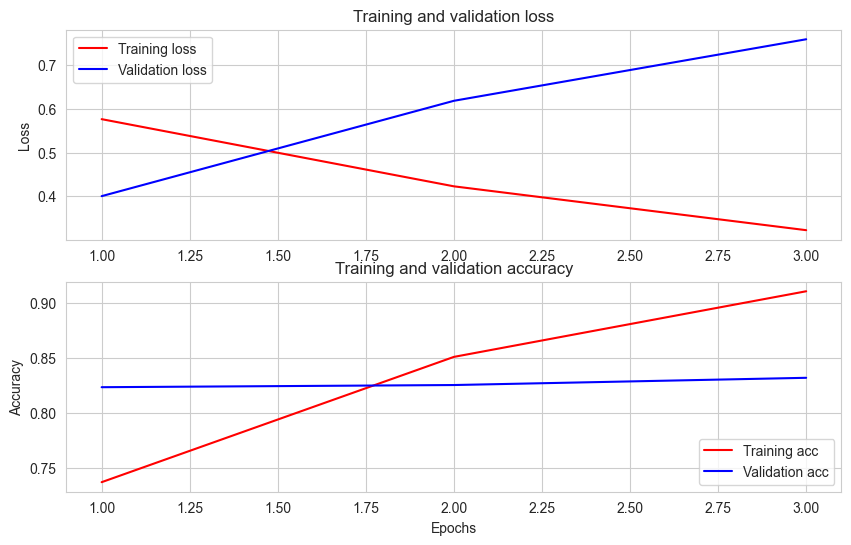

In [57]:
bert.iteration_plot()

In [58]:
ids = test_df[['id']]
pred = bert.predict(test_df['text'])

submission = pd.concat([ids, pred], axis=1).rename(columns={0: 'target'})
submission.to_csv("submission.csv", index=False)

102/102 [==============================] - 20s 188ms/step
